Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

Read dataset

In [3]:
# Load dataset
df = pd.read_csv("../datasets/aqi/generated/combined_aqi_bulk_modified.csv", parse_dates=["datetime"], index_col="datetime")

# Visualize data
df.head()

,o3 (ppm),pm2.5 (µg/m³)
datetime,,
2016-11-09 23:00:00+06:00,0.001,61.7
2016-11-10 00:00:00+06:00,0.001,67.8
2016-11-10 01:00:00+06:00,0.001,109.9
2016-11-10 02:00:00+06:00,0.001,127.4
2016-11-10 03:00:00+06:00,0.001,122.2


Resample the data based on hourly and daily frequencies

In [4]:
# Resample data to hourly frequency
df_hour = df.asfreq("h")

# Resample data to daily frequency
df_day = df.asfreq("D")

Check data quality and make necessary modifications

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

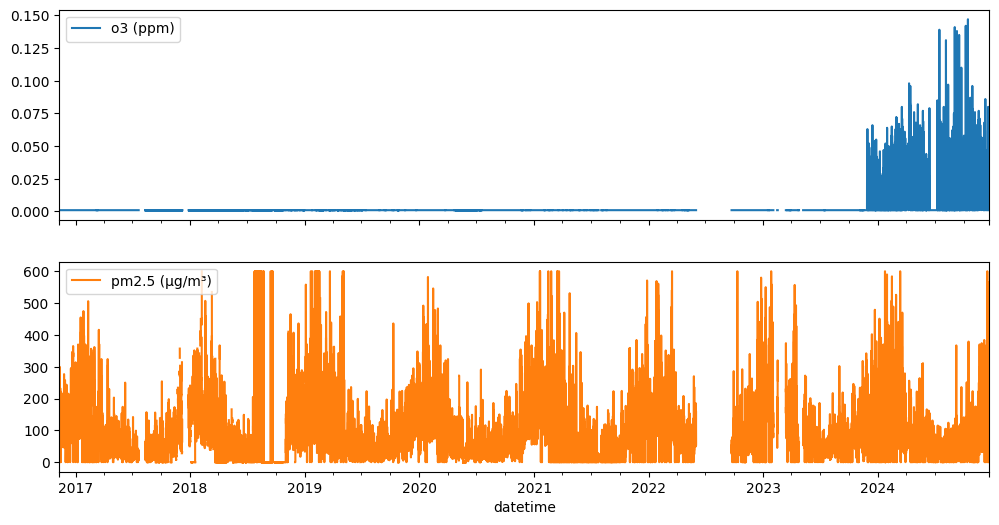

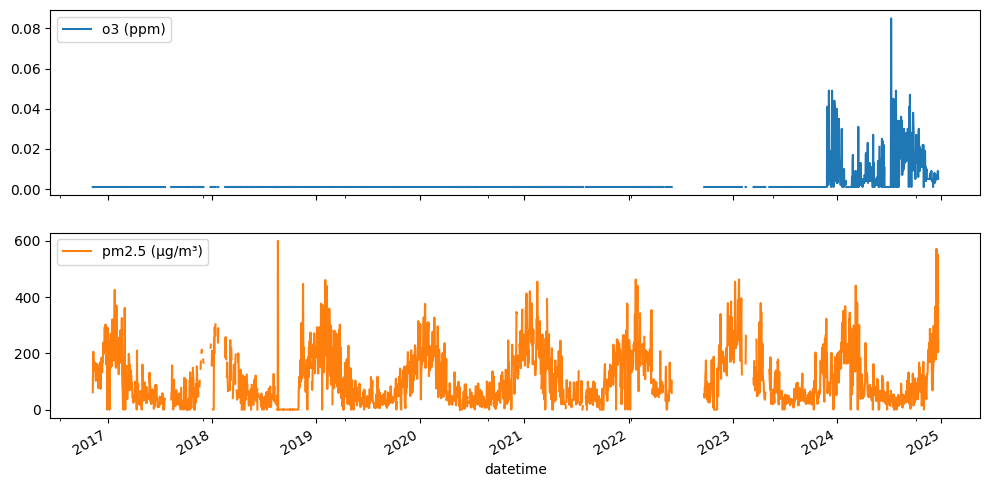

In [5]:
# Plot the data
df_hour.plot(figsize=(12, 6), subplots=True)
df_day.plot(figsize=(12, 6), subplots=True)

In [6]:
# Check for missing values
hourly_na = df_hour['pm2.5 (µg/m³)'].isna().sum()
daily_na = df_day['pm2.5 (µg/m³)'].isna().sum()

print(f"Number of missing values in hourly data: {hourly_na}")
print(f"Number of missing values in daily data: {daily_na}")

Number of missing values in hourly data: 8930
Number of missing values in daily data: 360


In [7]:
# Fill missing values
def fill_missing_with_mean(df: pd.DataFrame, key: str, format: str = "%m-%d") -> pd.DataFrame:
    df_copy = df.copy()
    df_copy['month_day'] = df_copy.index.strftime(format)
    daily_mean_by_date = df_copy.groupby("month_day")[key].mean()
    
    def _fill_missing(row):
        if np.isnan(row[key]):
            row[key] = daily_mean_by_date[row["month_day"]]
        return row
    
    df_copy = df_copy.apply(_fill_missing, axis=1)
    df_copy.drop(columns=["month_day"], inplace=True)
    # print(df_copy)
    return df_copy.copy()

In [8]:
# Fill the missingvalues for both dataframes
df_hour = fill_missing_with_mean(df_hour, "pm2.5 (µg/m³)", format="%m-%d %H")
df_day = fill_missing_with_mean(df_day, "pm2.5 (µg/m³)")

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

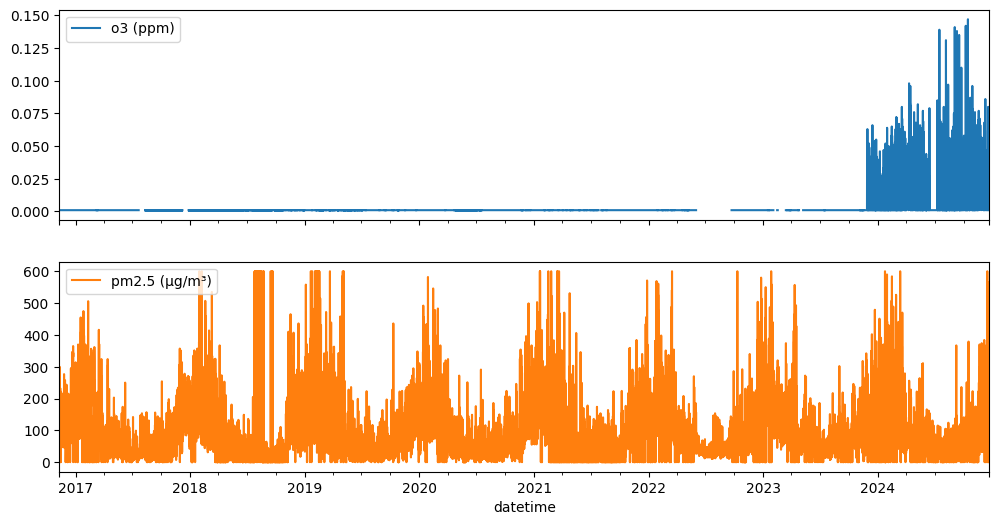

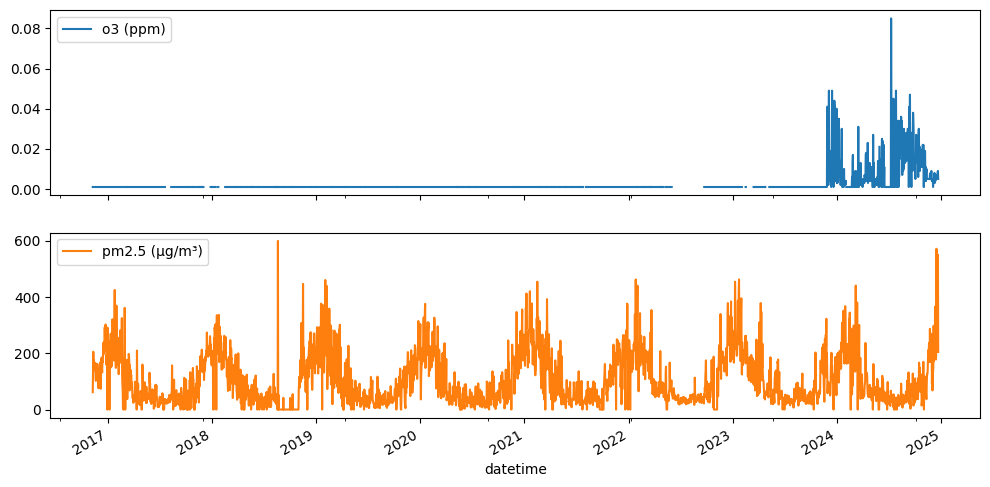

In [9]:
# Plot the data again
df_hour.plot(figsize=(12, 6), subplots=True)
df_day.plot(figsize=(12, 6), subplots=True)

In [10]:
# Check for missing values
hourly_na = df_hour['pm2.5 (µg/m³)'].isna().sum()
daily_na = df_day['pm2.5 (µg/m³)'].isna().sum()

print(f"Number of missing values in hourly data: {hourly_na}")
print(f"Number of missing values in daily data: {daily_na}")

Number of missing values in hourly data: 0
Number of missing values in daily data: 0


Text(0, 0.5, 'Power')

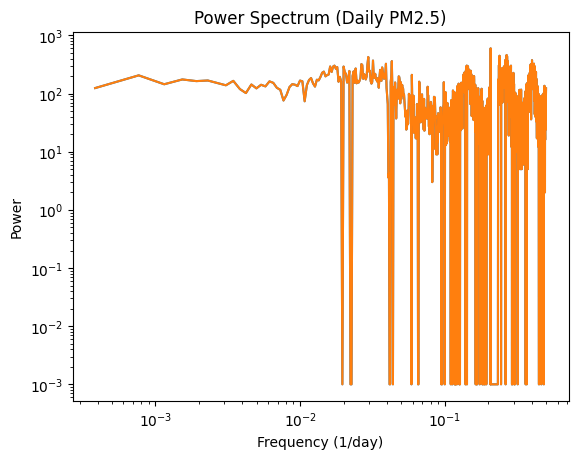

In [11]:
# Perform FFT on daily PM2.5 levels
fft = np.fft.fft(df_day.dropna())
frequencies = np.fft.fftfreq(len(fft), d=1)  # d=1 assumes daily frequency

# Power spectrum
power = np.abs(fft)

# Filter positive frequencies
positive_frequencies = frequencies[frequencies > 0]
positive_power = power[frequencies > 0]

# Plot Power Spectrum
plt.figure()
plt.loglog(positive_frequencies, positive_power)
plt.title("Power Spectrum (Daily PM2.5)")
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")

#### Analyze the data on various occassions

Decompose the PM2.5 data into components

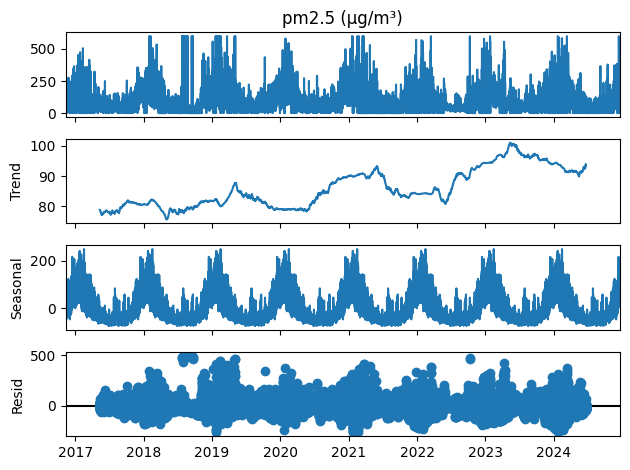

In [12]:
result = seasonal_decompose(df_hour["pm2.5 (µg/m³)"], model="additive", period=365 * 24)
result.plot()
plt.show()

Seasonal Analysis

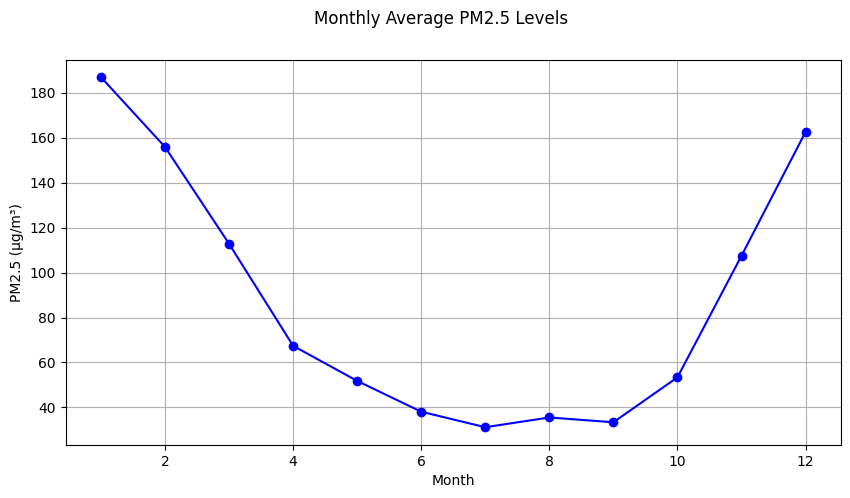

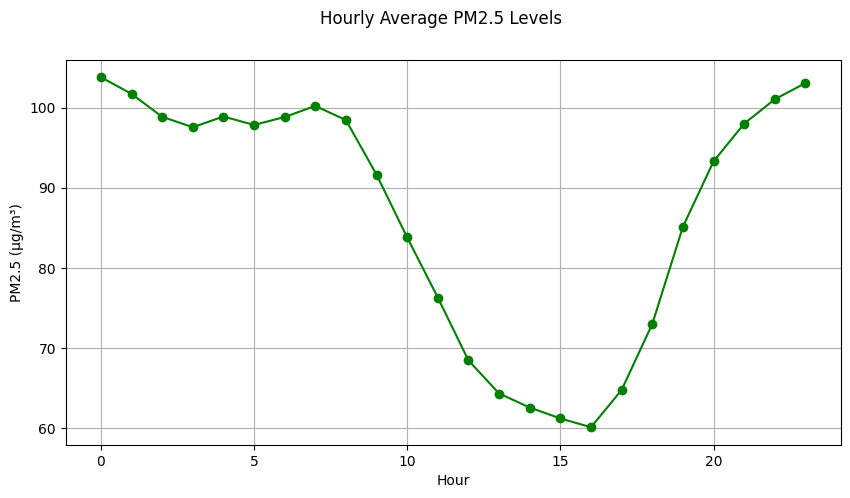

In [13]:
# Monthly averages
monthly_avg = df_hour.groupby(df_hour.index.month)[
    "pm2.5 (µg/m³)"].mean()
monthly_avg.plot(figsize=(10, 5), marker="o",
                 title="Monthly Average PM2.5 Levels", xlabel="Month", ylabel="PM2.5 (µg/m³)", grid=True, color="blue", subplots=True,)
plt.show()

# Hourly averages
hourly_avg = df_hour.groupby(df_hour.index.hour)["pm2.5 (µg/m³)"].mean()
hourly_avg.plot(figsize=(10, 5), marker="o",
                title="Hourly Average PM2.5 Levels", xlabel="Hour", ylabel="PM2.5 (µg/m³)", grid=True, color="green", subplots=True,)
plt.show()

Safe Hour Heatmap

In [14]:
# Skip incomplete year
df_hour_full: pd.DataFrame = df_hour.loc[df_hour.index.year > 2016]

# Define a function to plot the heatmap of the PM2.5 levels by month and hour of the day
def plot_heatmap(
    df: pd.DataFrame, 
    by,
    title: str, 
    xlabel: str, 
    ylabel: str,
    bar_label: str,
    figsize: tuple = (12, 6),
) -> None:
    # Create a pivot table for the heatmap
    heatmap_data = (
        df["pm2.5 (µg/m³)"]
        .groupby(by)
        .mean()
        .unstack(level=0)
    )

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        heatmap_data,
        cmap="RdYlGn_r",
        cbar_kws={"label": bar_label},
        annot=False,
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

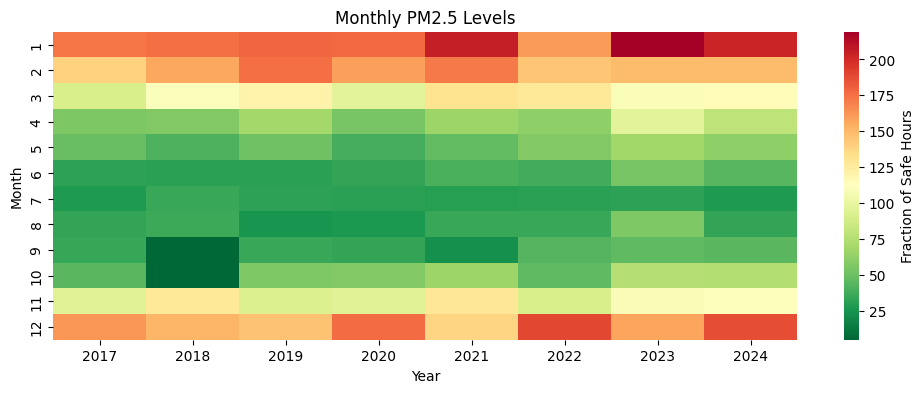

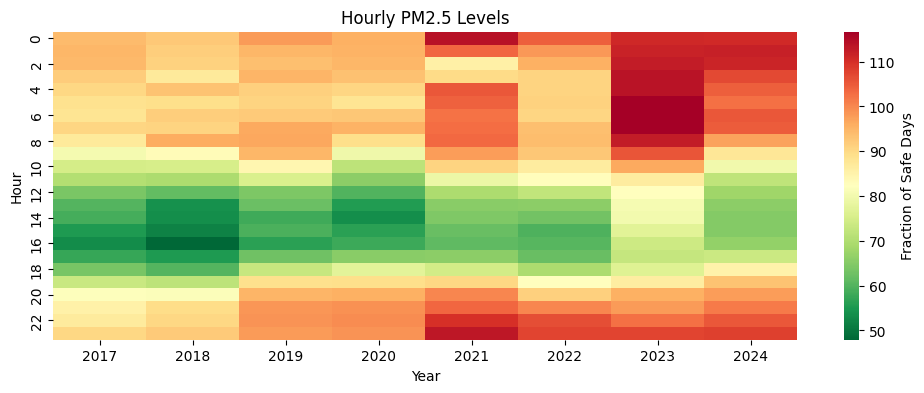

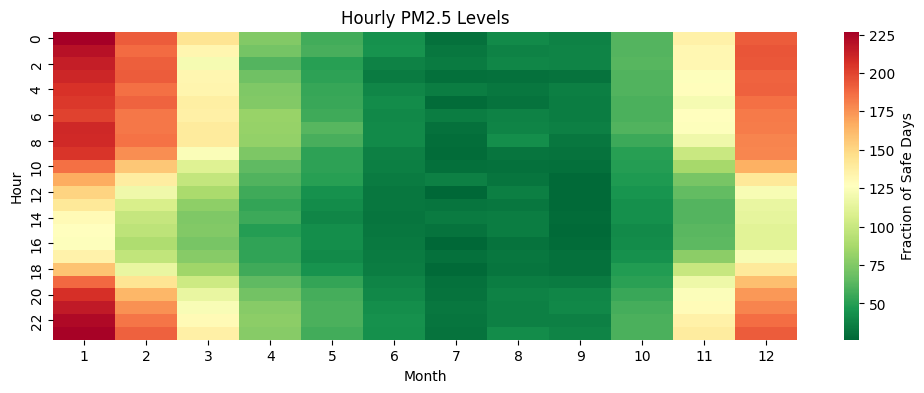

In [15]:
# Monthly per year levels
plot_heatmap(
    df=df_hour_full, 
    by=[df_hour_full.index.year, df_hour_full.index.month],
    title="Monthly PM2.5 Levels", 
    xlabel="Year", 
    ylabel="Month", 
    bar_label="Fraction of Safe Hours",
    figsize=(12, 4),
)

# Hourly per hear levels
plot_heatmap(
    df=df_hour_full, 
    by=[df_hour_full.index.year, df_hour_full.index.hour],
    title="Hourly PM2.5 Levels", 
    xlabel="Year", 
    ylabel="Hour", 
    bar_label="Fraction of Safe Days",
    figsize=(12, 4),
)

# Hourly per month levels
plot_heatmap(
    df=df_hour_full, 
    by=[df_hour_full.index.month, df_hour_full.index.hour],
    title="Hourly PM2.5 Levels", 
    xlabel="Month", 
    ylabel="Hour", 
    bar_label="Fraction of Safe Days",
    figsize=(12, 4),
)

/tmp/ipykernel_17629/4016243163.py:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate()  # Interpolate missing data


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       911
           1       0.91      0.84      0.88      1213
           2       0.81      0.87      0.84      3128
           3       0.83      0.85      0.84      3968
           4       0.72      0.63      0.67      2261
           5       0.84      0.86      0.85      2492

    accuracy                           0.82     13973
   macro avg       0.82      0.81      0.81     13973
weighted avg       0.81      0.82      0.81     13973



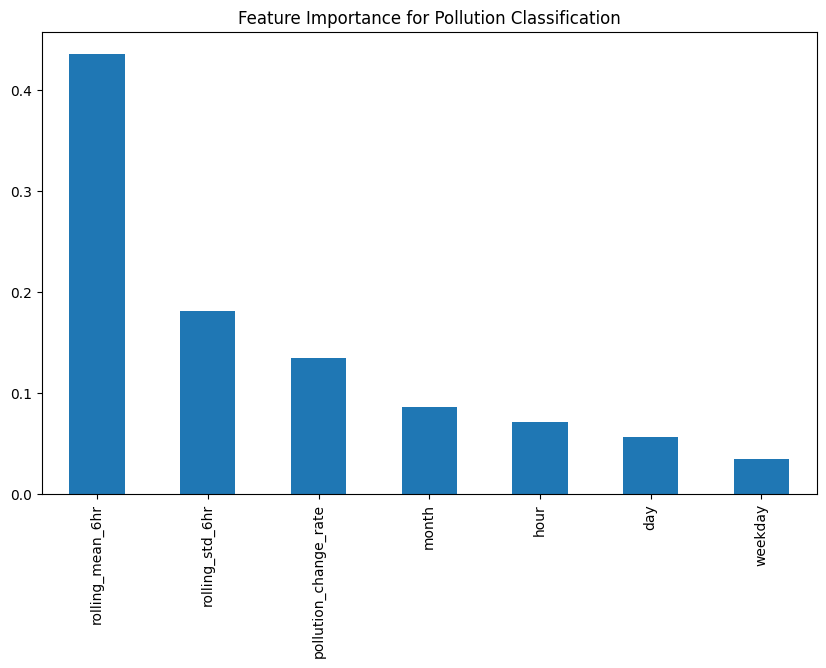

Mean Squared Error: 476.3759769769517


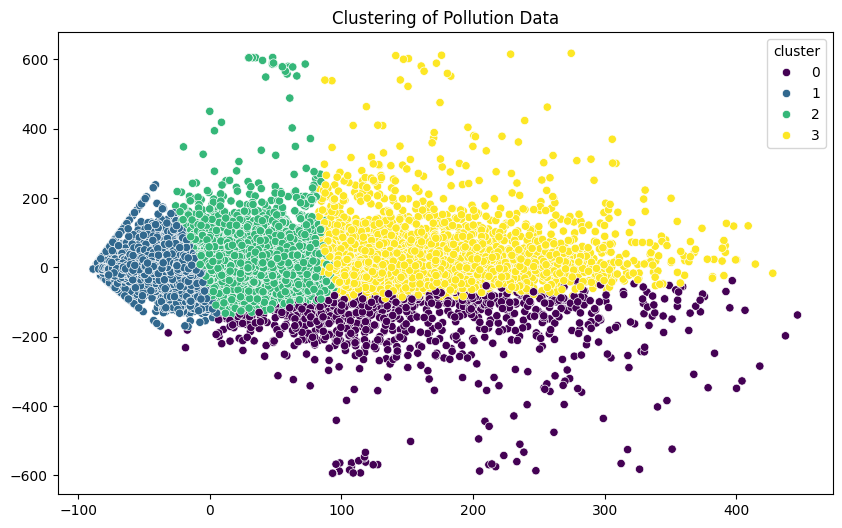

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import xgboost as xgb

# Load the dataset
data = df_hour_full.copy()
data["hour"] = data.index.hour
data["day"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year
data["weekday"] = data.index.weekday  # Monday=0, Sunday=6

# Feature Engineering
data["rolling_mean_6hr"] = data["pm2.5 (µg/m³)"].rolling(window=6, min_periods=1).mean()
data["rolling_std_6hr"] = data["pm2.5 (µg/m³)"].rolling(window=6, min_periods=1).std()
data["pollution_change_rate"] = data["pm2.5 (µg/m³)"].diff()  # Hourly change
data["extreme_flag"] = (data["pm2.5 (µg/m³)"] > data["pm2.5 (µg/m³)"].quantile(0.95)).astype(int)  # 95th percentile

# Categorize pollution levels
def categorize_pm25(value):
    if value <= 9.0:
        return "Healthy"
    elif value <= 35.4:
        return "Moderate"
    elif value <= 55.4:
        return "Unhealthy for Sensitive"    
    elif value <= 125.4:
        return "Unhealthy"
    elif value <= 225.4:
        return "Very Unhealthy"
    else:
        return "Hazardous"

data["category"] = data["pm2.5 (µg/m³)"].apply(categorize_pm25)

# Handle Missing Values
data = data.interpolate()  # Interpolate missing data

# Split Dataset
features = ["hour", "day", "month", "weekday", "rolling_mean_6hr", "rolling_std_6hr", "pollution_change_rate"]
X = data[features]
# Handle Missing Values in Features
imputer = SimpleImputer(strategy="mean")  # Replace NaNs with the mean of the column
X = imputer.fit_transform(X)

y = LabelEncoder().fit_transform(data["category"])  # Encode categories for classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the Classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind="bar")
plt.title("Feature Importance for Pollution Classification")
plt.show()

# Regression: PM2.5 Forecasting
X_reg = X.copy()
y_reg = data["pm2.5 (µg/m³)"]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
reg.fit(X_train_reg, y_train_reg)

y_pred_reg = reg.predict(X_test_reg)
print("Mean Squared Error:", mean_squared_error(y_test_reg, y_pred_reg))

# Clustering Analysis
kmeans = KMeans(n_clusters=4, random_state=42)
data["cluster"] = kmeans.fit_predict(X)

# Visualize Clusters
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=data["cluster"], palette="viridis")
plt.title("Clustering of Pollution Data")
plt.show()


Long term trends

<Axes: xlabel='datetime'>

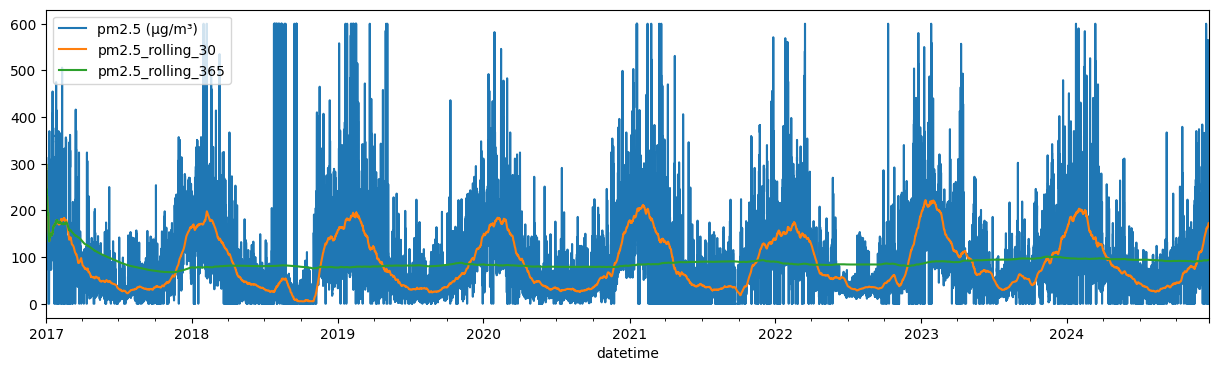

In [56]:
# Moving average to smoothen the data
data['pm2.5_rolling_365'] = data["pm2.5 (µg/m³)"].rolling(window='365D', min_periods=1).mean()
data['pm2.5_rolling_30'] = data["pm2.5 (µg/m³)"].rolling(window='30D', min_periods=1).mean()
data[["pm2.5 (µg/m³)", 'pm2.5_rolling_30', 'pm2.5_rolling_365']].plot(figsize=(15, 4))

Peak analysis

In [31]:
# Identify the hours or days with the highest PM2.5 levels for each year/month.
monthly_max = data.groupby(['year', 'month'])["pm2.5 (µg/m³)"].max()
monthly_max.head()

year  month
2017  1        474.8
      2        505.9
      3        416.0
      4        324.0
      5        203.0
Name: pm2.5 (µg/m³), dtype: float64

Comparison across seasons

In [33]:
# Season based features
data['season'] = data['month'] % 12 // 3 + 1

<Axes: xlabel='season'>

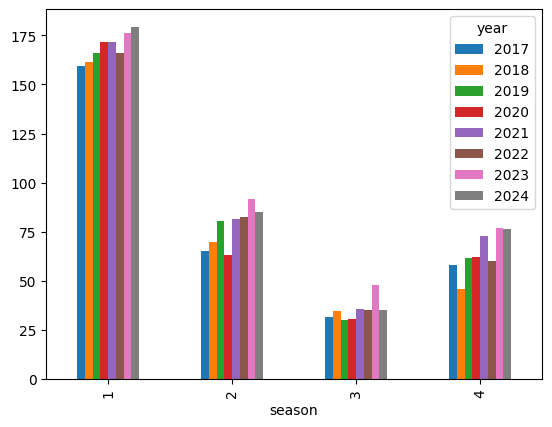

In [34]:
# Plot seasonal averages over multiple years to compare how pollution differs by season
seasonal_avg = data.groupby(['season', 'year'])["pm2.5 (µg/m³)"].mean().unstack()
seasonal_avg.plot(kind='bar')

Lagged correlations

<Axes: >

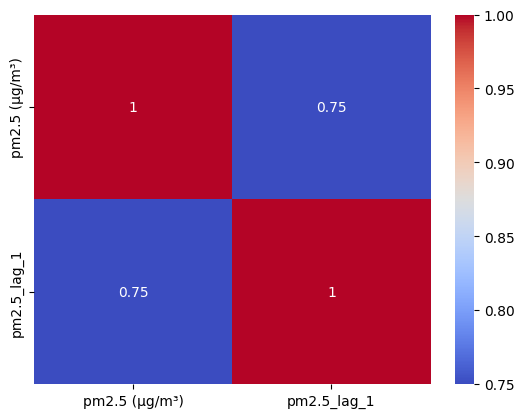

In [35]:
data_day = df_day.copy()
data_day['pm2.5_lag_1'] = data_day["pm2.5 (µg/m³)"].shift(1)
lagged_correlation = data_day[["pm2.5 (µg/m³)", 'pm2.5_lag_1']].corr()

# Plot the correlation matrix
sns.heatmap(lagged_correlation, annot=True, cmap='coolwarm')

Anomaly detection

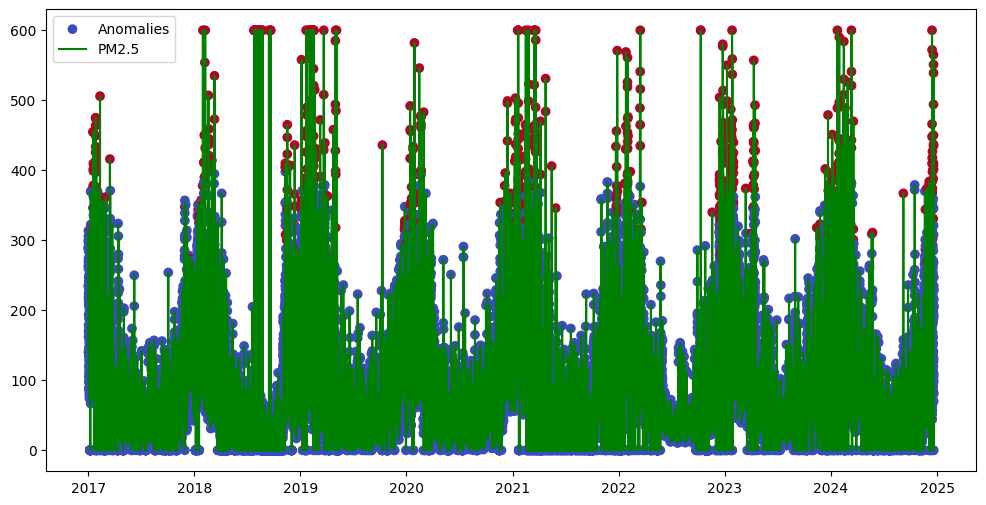

In [41]:
from sklearn.ensemble import IsolationForest

# Prepare features
X_anomaly = data[["pm2.5 (µg/m³)", 'hour', 'month']].fillna(0)

# Fit Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
data['anomaly'] = model.fit_predict(X_anomaly)

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.scatter(data.index, data["pm2.5 (µg/m³)"], c=data['anomaly'], cmap='coolwarm_r', label='Anomalies')
plt.plot(data["pm2.5 (µg/m³)"], label='PM2.5', color='green')
plt.legend()
plt.show()

/tmp/ipykernel_17629/2620541697.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="RdYlGn_r")


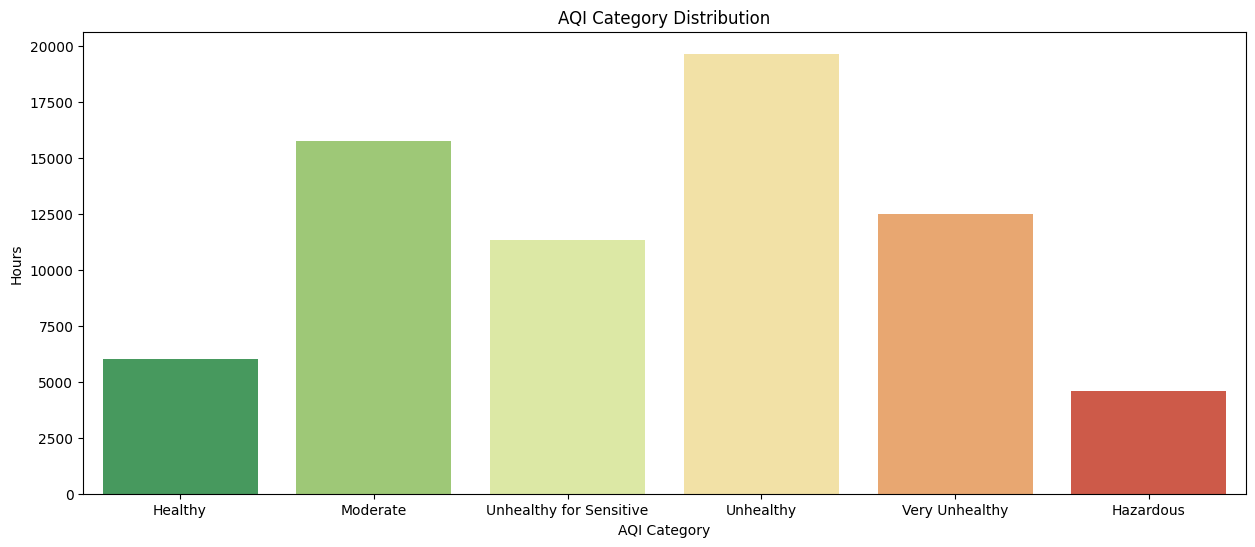

In [ ]:
# Count categories
data['category'] = pd.Categorical(data['category'], categories=["Healthy", "Moderate", "Unhealthy for Sensitive", "Unhealthy", "Very Unhealthy", "Hazardous"])
category_counts = data['category'].value_counts()

# Visualize categories
plt.figure(figsize=(15, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="RdYlGn_r")
plt.title('AQI Category Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Hours')
plt.show()

Seasonal impact analysis

/tmp/ipykernel_17629/1018978654.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = data.resample('M')["pm2.5 (µg/m³)"].mean()


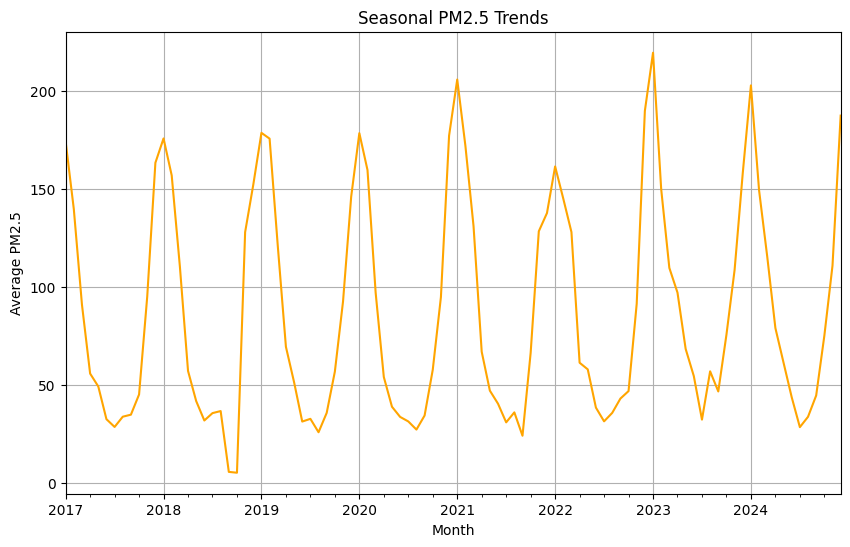

In [52]:
# Calculate monthly averages
monthly_avg = data.resample('M')["pm2.5 (µg/m³)"].mean()

# Plot seasonal trends
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='line', color='orange')
plt.title("Seasonal PM2.5 Trends")
plt.xlabel("Month")
plt.ylabel("Average PM2.5")
plt.grid()
plt.show()

Pollution patterns

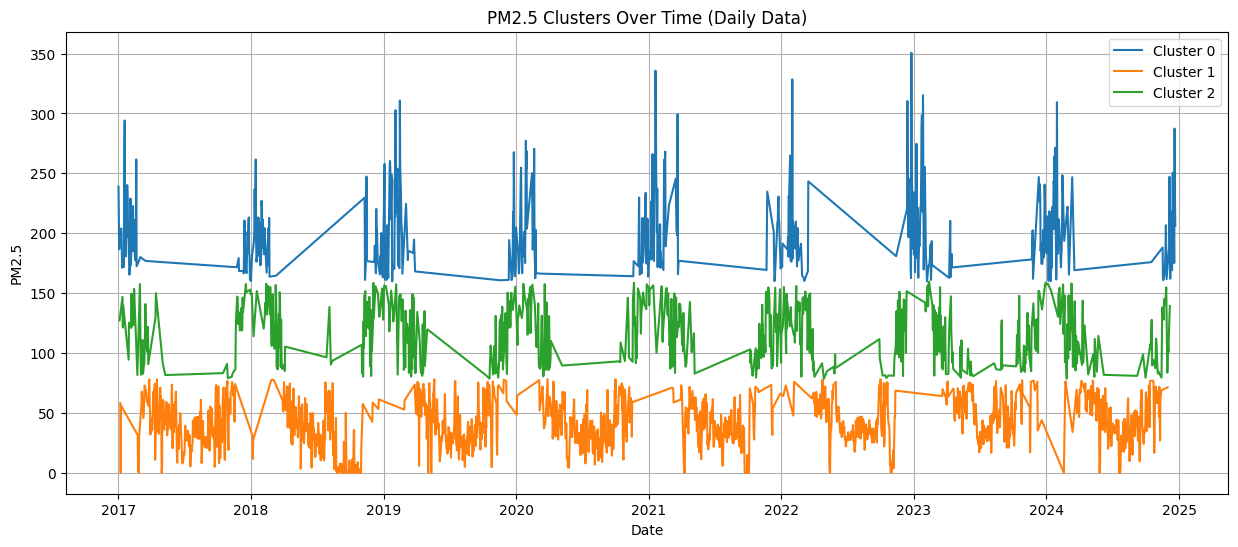

In [54]:
# Use daily mean PM2.5
daily_data = data.resample('D')["pm2.5 (µg/m³)"].mean().dropna()

# Prepare features for clustering
X_clustering = daily_data.values.reshape(-1, 1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
daily_data_clusters = kmeans.fit_predict(X_clustering)

# Add the clusters back to daily_data as a new column
daily_data = daily_data.to_frame(name="pm2.5 (µg/m³)")
daily_data['Cluster'] = daily_data_clusters

# Visualize clusters
plt.figure(figsize=(15, 6))
for cluster in range(3):
    cluster_data = daily_data[daily_data['Cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data["pm2.5 (µg/m³)"], label=f'Cluster {cluster}')
plt.legend()
plt.title("PM2.5 Clusters Over Time (Daily Data)")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.grid()
plt.show()


              precision    recall  f1-score   support

           0       0.84      0.83      0.83     10999
           1       0.82      0.82      0.82      9961

    accuracy                           0.83     20960
   macro avg       0.83      0.83      0.83     20960
weighted avg       0.83      0.83      0.83     20960



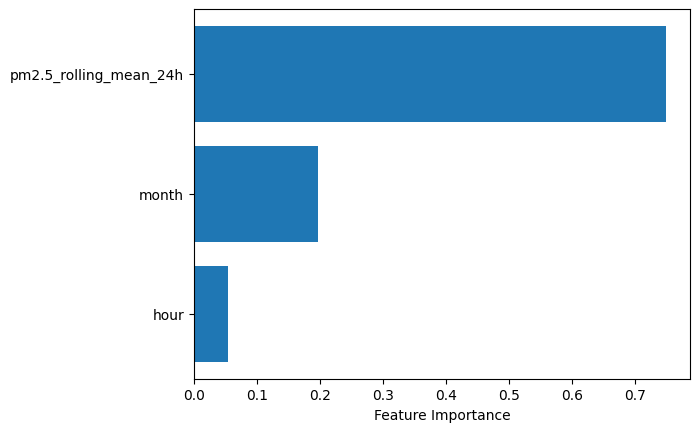

In [61]:
# Label data
data['safe'] = (data["pm2.5 (µg/m³)"] <= 55.4).astype(int)
data['pm2.5_rolling_mean_24h'] = data["pm2.5 (µg/m³)"].rolling(window='24h', min_periods=1).mean()

# Prepare features and target
X = data[['hour', 'month', 'pm2.5_rolling_mean_24h']].fillna(0)
y = data['safe']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance
importances = rf_model.feature_importances_
plt.barh(X.columns, importances)
plt.xlabel('Feature Importance')
plt.show()

In [ ]:
import shap

# Function to batch SHAP calculations
def batched_shap_calculations(explainer, X_test, batch_size=1000):
    shap_values = []
    for i in range(0, len(X_test), batch_size):
        X_batch = X_test.iloc[i:i + batch_size]
        shap_values.append(explainer(X_batch))
    return np.concatenate(shap_values)

# Initialize SHAP Explainer
explainer = shap.Explainer(rf_model, X_train)

# Batch size for SHAP explanations
batch_size = 1000
shap_values = batched_shap_calculations(explainer, X_test, batch_size=batch_size)

# Visualize SHAP summary
shap.summary_plot(shap_values, X_test)

/tmp/ipykernel_17629/3002628485.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_data = data.resample('Y')["pm2.5 (µg/m³)"].mean().dropna()


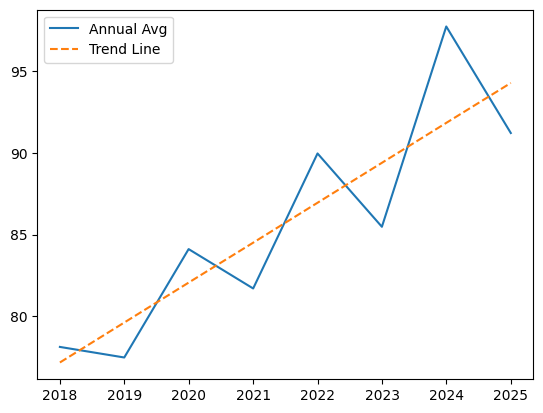

In [58]:
from sklearn.linear_model import LinearRegression

# Annual averages
annual_data = data.resample('Y')["pm2.5 (µg/m³)"].mean().dropna()
X = np.arange(len(annual_data)).reshape(-1, 1)
y = annual_data.values

# Fit trend line
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

# Plot trend
plt.plot(annual_data.index, annual_data, label='Annual Avg')
plt.plot(annual_data.index, trend, label='Trend Line', linestyle='--')
plt.legend()
plt.show()

In [59]:
data['extreme'] = (data["pm2.5 (µg/m³)"] > 225.5).astype(int)

# Logistic regression for prediction
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85     10999
           1       0.81      0.89      0.85      9961

    accuracy                           0.85     20960
   macro avg       0.85      0.85      0.85     20960
weighted avg       0.85      0.85      0.85     20960

